In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import fastjet as fj
import random
import copy

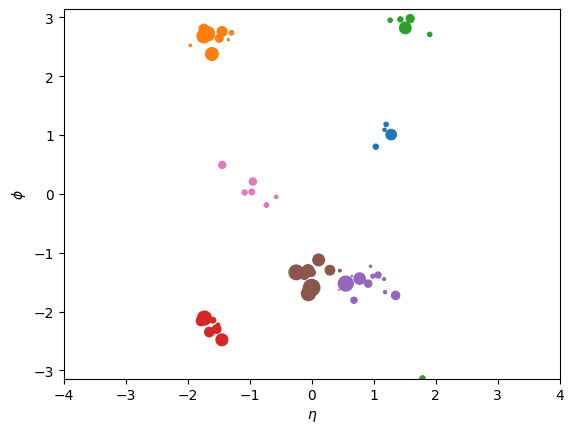

In [75]:
def generate_particles(n_jets):
    particles = []
    #np.random.seed(8)
    eta_values_list = []
    phi_values_list = []
    energy_values_list = []

    for nj in range(n_jets):
        phi_0 = np.random.uniform(-np.pi, np.pi)
        eta_0 = np.random.uniform(-3, 3)
        Nj = np.random.randint(5, 15)
        eta_values = []
        phi_values = []
        energy_values = []
        for n_part in range(Nj):
            E = np.random.exponential(4)
            eta = np.random.normal(eta_0, 0.2)
            phi = np.random.normal(phi_0, 0.2)
            if phi > np.pi:
                phi = - 2*np.pi + phi
            elif phi < -np.pi:
                phi = 2*np.pi + phi
            px = E * np.cos(phi)/np.cosh(eta)
            py = E * np.sin(phi)/np.cosh(eta)
            pz = E * np.tanh(eta)
            particles.append(fj.PseudoJet(px, py, pz, E))
            eta_values.append(eta)
            phi_values.append(phi)
            energy_values.append(E)
        
        eta_values_list.append(eta_values)
        phi_values_list.append(phi_values)
        energy_values_list.append(energy_values)

    return particles, eta_values_list, phi_values_list, energy_values_list

# Generate particles
#n_jets = np.random.randint(5, 15)
n_jets = 7
R= 0.2
particles, eta_values_list, phi_values_list, energy_values_list = generate_particles(n_jets)

# Convert particle data to numpy array for clustering
particle_data = np.array([[p.eta(), p.phi(), p.pt(), p.e(), p.px(), p.py(), p.pz()] for p in particles])
for i in range(len(phi_values_list)):
    plt.scatter(eta_values_list[i], phi_values_list[i], s=[10*e for e in energy_values_list[i]])
    plt.ylabel(r'$\phi$')
    plt.xlabel(r'$\eta$')
    plt.ylim(-np.pi, np.pi)
    plt.xlim(-4, 4)

In [76]:
# Create a copy of the particle data for both algorithms
particle_data_for_fastjet = copy.deepcopy(particle_data)
particle_data_for_custom = copy.deepcopy(particle_data)

In [77]:
# Run the FastJet algorithm
jet_def = fj.JetDefinition(fj.cambridge_algorithm, 1.2)
fastjet_cluster_sequence = fj.ClusterSequence(particles, jet_def)
fastjet_clusters = fastjet_cluster_sequence.inclusive_jets(ptmin=0.0)
print(len(fastjet_clusters))


6


In [78]:
def delta_r(p1, p2, R):
    delta_eta = p1[0] - p2[0]
    delta_phi = np.abs(p1[1] - p2[1])
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi
    delta_R2 = delta_eta**2 + delta_phi**2
    return delta_R2 / R**2

def calculate_sigma(pseudojet):
    n = len(pseudojet)
    if n < 2:
        return 0.0
    pT_weights = np.array([p[2] for p in pseudojet])
    total_pT = np.sum(pT_weights)
    delta_Rs = [delta_r(p1, p2, 1.0) for i, p1 in enumerate(pseudojet) for j, p2 in enumerate(pseudojet) if i < j]
    weighted_sum = np.sum([w1 * w2 * dR for (w1, w2, dR) in zip(pT_weights, pT_weights, delta_Rs)])
    weighted_mean = weighted_sum / total_pT**2
    weighted_sum_sq = np.sum([(w1 * w2 * dR)**2 for (w1, w2, dR) in zip(pT_weights, pT_weights, delta_Rs)])
    variance = (weighted_sum_sq / total_pT**2) - weighted_mean**2
    if variance < 0:
        variance = 0
    sigma_i = np.sqrt(variance)
    return sigma_i

def merge_particles(data, imin, jmin):
    px_sum = data[imin, 4] + data[jmin, 4]
    py_sum = data[imin, 5] + data[jmin, 5]
    pz_sum = data[imin, 6] + data[jmin, 6]
    E_sum = data[imin, 3] + data[jmin, 3]

    pt_sum = np.sqrt(px_sum**2 + py_sum**2)
    magn_p = np.sqrt(px_sum**2 + py_sum**2 + pz_sum**2)
    eta_sum = 0.5 * np.log((magn_p + pz_sum) / (magn_p - pz_sum))
    phi_sum = np.arctan2(py_sum, px_sum)
    if phi_sum > np.pi:
        phi_sum = -2 * np.pi + phi_sum
    elif phi_sum < -np.pi:
        phi_sum = 2 * np.pi + phi_sum

    data = np.vstack([data, [eta_sum, phi_sum, pt_sum, E_sum, px_sum, py_sum, pz_sum]])
    return data

def update_dis(new_row, dist_matrix):
    size = dist_matrix.shape[0] + 1
    new_dist_matrix = np.zeros((size, size))
    new_dist_matrix[:-1, :-1] = dist_matrix
    new_dist_matrix[-1,:] = new_row
    new_dist_matrix[:-1,-1] = new_row[:-1]
    new_dist_matrix[-1,-1] = np.inf
    if np.min(new_dist_matrix) < 1e-2:
        indices = np.unravel_index(np.argmin(new_dist_matrix), new_dist_matrix.shape)
        new_dist_matrix[indices[0],indices[1]] = np.inf
    return new_dist_matrix

def find_daughters(binary_tree, index, given_index):
    daughters = []

    # Base case: if index is not in the tree, return empty list
    if index not in binary_tree:
        return daughters

    # Recursive case
    node = binary_tree[index]
    if 'left' in node:
        left_index = node['left']
        if left_index < given_index:
            daughters.append(left_index)
        daughters.extend(find_daughters(binary_tree, left_index, given_index))
    if 'right' in node:
        right_index = node['right']
        if right_index < given_index:
            daughters.append(right_index)
        daughters.extend(find_daughters(binary_tree, right_index, given_index))

    return daughters

In [79]:
def Custom_dynrad(R, data):
    start_time = time.time()
    dendogram = []
    merge_count = 0
    jets, mergers, jets_constituents = [], [], []
    n_particles = data.shape[0]
    distances = np.full((n_particles, n_particles), np.inf)
    pseudojets = {i: [data[i]] for i in range(n_particles)}

    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            R_di = R + calculate_sigma(pseudojets[i])#
            distances[i, j] = delta_r(data[i], data[j], R_di)
            distances[j, i] = distances[i, j]
    dist_matrix = np.copy(distances)

    np.set_printoptions(linewidth=np.inf)

    while True:
        indices = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
        min_dist = dist_matrix[indices[0], indices[1]]
        if min_dist < R:
            data = merge_particles(data, indices[0], indices[1])
            dendogram.append([merge_count + n_particles, indices[0], indices[1], min_dist])
            merge_count += 1

            new_index = data.shape[0] - 1
            pseudojets[new_index] = pseudojets.pop(indices[0]) + pseudojets.pop(indices[1])

            append_R = [delta_r(data[j], data[-1], R + calculate_sigma(pseudojets[j])) if j in pseudojets else np.inf for j in range(data.shape[0])]
            dist_matrix = update_dis(append_R, dist_matrix)
            dist_matrix[indices[0], :], dist_matrix[indices[1], :] = np.inf, np.inf
            dist_matrix[:, indices[0]], dist_matrix[:, indices[1]] = np.inf, np.inf
            for i, j, k, _ in dendogram:
                dist_matrix[j, :], dist_matrix[k, :] = np.inf, np.inf
                dist_matrix[:, j], dist_matrix[:, k] = np.inf, np.inf

        elif min_dist >= R and min_dist < np.inf:
            if indices[0] not in mergers and indices[1] not in mergers:
                jets.append(data[indices[0]])
                jets.append(data[indices[1]])
                mergers.append(indices[0])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge, indices[0]], dist_matrix[indices[0], merge] = np.inf, np.inf
                    dist_matrix[merge, indices[1]], dist_matrix[indices[1], merge] = np.inf, np.inf
            if indices[0] in mergers and indices[1] not in mergers:
                jets.append(data[indices[1]])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge, indices[1]], dist_matrix[indices[1], merge] = np.inf, np.inf
            if indices[0] not in mergers and indices[1] in mergers:
                jets.append(data[indices[0]])
                mergers.append(indices[0])
                for merge in mergers:
                    dist_matrix[merge, indices[0]], dist_matrix[indices[0], merge] = np.inf, np.inf

        elif min_dist == np.inf:
            print(f"Loop Broken in {round(time.time() - start_time, 4)}s")
            break

    t = time.time()
    tree = {}
    dendogram = np.array(dendogram)
    for entry in dendogram:
        merged_index, index1, index2, _ = entry
        if merged_index not in tree:
            tree[merged_index] = {'left': index1, 'right': index2}
        else:
            print(f"Node {merged_index} is already defined in the tree.")

    for merge in mergers:
        children = []
        children = find_daughters(tree, merge, n_particles)
        jet_constituents = []
        for child in children:
            jet_constituents.append(particle_data_for_custom[int(child)])
        jets_constituents.append(jet_constituents)
    print(f"Time taken for finding constituents {round(time.time() - t, 6)}s")

    return jets, jets_constituents, tree, mergers

In [80]:
jets_r, jets_constituents1, tree1, mergers1 = Custom_dynrad(0.8, particle_data_for_custom)
len(jets)

Loop Broken in 0.3486s
Time taken for finding constituents 0.000978s


7

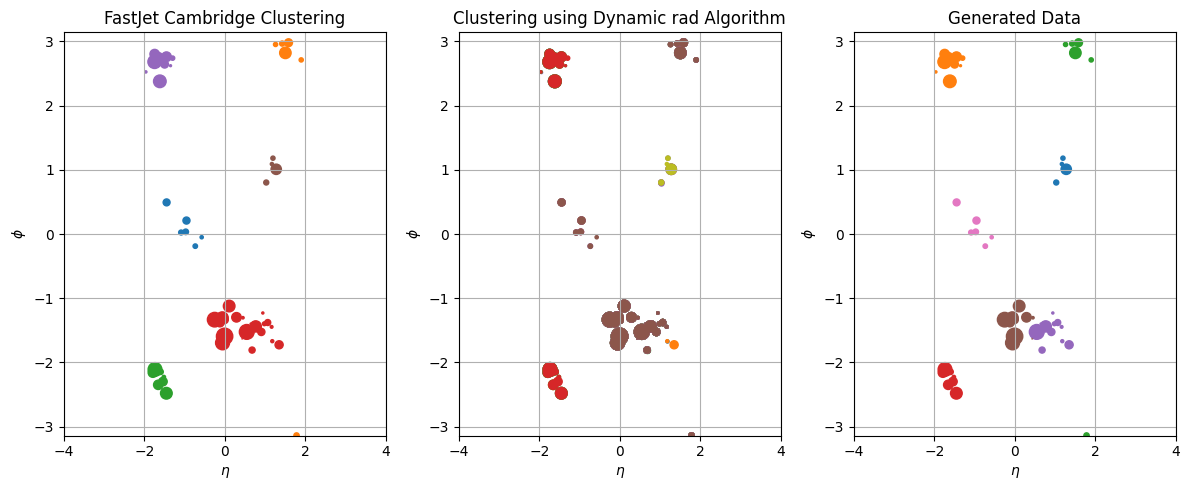

In [81]:
# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot results from FastJet Cambridge/Aachen Algorithm
for jet in fastjet_clusters:
    constituents = jet.constituents()
    phi_values = []
    for p in constituents:
        if p.phi() > np.pi:
            phi_values.append(p.phi() - 2 * np.pi)
        elif p.phi() < -np.pi:
            phi_values.append(p.phi() + 2 * np.pi)
        else:
            phi_values.append(p.phi())
    eta_values = [p.eta() for p in constituents]
    energy_values = [p.e() for p in constituents]
    axes[0].scatter(eta_values, phi_values, s=[10 * e for e in energy_values], alpha=1, label=f'Jet with pT={jet.pt():.2f}')
axes[0].set_ylim(-np.pi, np.pi)
axes[0].set_xlim(-4, 4)
axes[0].grid(True)
axes[0].set_title('FastJet Cambridge Clustering')
axes[0].set_xlabel(r'$\eta$')
axes[0].set_ylabel(r'$\phi$')

# Plot results from Custom Cambridge Algorithm
for constituents in jets_constituents1:
    consti_eta, consti_phi, consti_e = [],[],[]
    for i in range(len(constituents)):
        consti_eta.append(constituents[i][0])
        if constituents[i][1]>np.pi:
            consti_phi.append(constituents[i][1]-2*np.pi)
        elif constituents[i][1]<-np.pi:
            consti_phi.append(constituents[i][1]+2*np.pi)
        else:
            consti_phi.append(constituents[i][1])
        consti_e.append(constituents[i][3])
        axes[1].scatter(consti_eta, consti_phi, s=[10*e for e in consti_e])
axes[1].set_ylim(-np.pi,np.pi)
axes[1].set_xlim(-4,4)
axes[1].grid(True)
axes[1].set_xlabel(r'$\eta$')
axes[1].set_ylabel(r'$\phi$')
axes[1].set_title("Clustering using Dynamic rad Algorithm")

# Original plot
for i in range(len(phi_values_list)):
    axes[2].scatter(eta_values_list[i], phi_values_list[i], s=[10*e for e in energy_values_list[i]])
    axes[2].set_ylabel(r'$\phi$')
    axes[2].set_xlabel(r'$\eta$')
    axes[2].set_ylim(-np.pi, np.pi)
    axes[2].set_xlim(-4, 4)
    axes[2].grid(True)
    axes[2].set_title("Generated Data")

plt.tight_layout()
plt.show()


In [82]:
def Custom_CA(R:float, data:np.array):
    start_time = time.time()
    dendogram = []
    merge_count = 0
    jets, mergers, jets_constituents = [],[],[]
    n_particles = data.shape[0]
    distances = np.full((n_particles, n_particles), np.inf)
    
    # Calculate the distance matrix and beam distances
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j], R)
            distances[j, i] = distances[i, j]
    dist_matrix = np.copy(distances)
    
    np.set_printoptions(linewidth=np.inf)
    
    while(1):
        indices = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
        min_dist = dist_matrix[indices[0], indices[1]]
        if min_dist < R:
            data = merge_particles(data, indices[0], indices[1])
            dendogram.append([merge_count+n_particles,indices[0],indices[1],min_dist])
            merge_count+=1
            append_R = [delta_r(data[j], data[-1], R) for j in range(data.shape[0])]
            dist_matrix = update_dis(append_R, dist_matrix)
            dist_matrix[indices[0],:], dist_matrix[indices[1],:] = np.inf, np.inf
            dist_matrix[:,indices[0]], dist_matrix[:,indices[1]] = np.inf, np.inf
            for i,j,k,_ in dendogram:
                dist_matrix[j,:], dist_matrix[k,:] = np.inf, np.inf
                dist_matrix[:,j], dist_matrix[:,k] = np.inf, np.inf
        
        elif min_dist >= R and min_dist < np.inf:
            if (indices[0] not in mergers) and (indices[1] not in mergers):
                jets.append(data[indices[0]])
                jets.append(data[indices[1]])
                mergers.append(indices[0])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge,indices[0]], dist_matrix[indices[0],merge] = np.inf, np.inf
                    dist_matrix[merge,indices[1]], dist_matrix[indices[1],merge] = np.inf, np.inf
            if (indices[0] in mergers) and (indices[1] not in mergers):
                jets.append(data[indices[1]])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge,indices[1]], dist_matrix[indices[1],merge] = np.inf, np.inf
            if (indices[0] not in mergers) and (indices[1] in mergers):
                jets.append(data[indices[0]])
                mergers.append(indices[0])
                for merge in mergers:
                    dist_matrix[merge,indices[0]], dist_matrix[indices[0],merge] = np.inf, np.inf
                
        elif min_dist == np.inf:
            # mergers.append(data.shape[0]-1)
            print(f"Loop Broken in {round(time.time()-start_time,4)}s")
            break

    t = time.time()
    tree = {} 
    dendogram = np.array(dendogram)
    for entry in dendogram:
        merged_index, index1, index2,_ = entry
        if merged_index not in tree:
            tree[merged_index] = {'left': index1, 'right': index2}
        else:
            print(f"Node {merged_index} is already defined in the tree.")
    
    for merge in mergers:
        children = []
        children = find_daughters(tree, merge, n_particles)
        jet_constituents = []
        for child in children:
            jet_constituents.append(particle_data_for_custom[int(child)])
        jets_constituents.append(jet_constituents)
    print(f"Time taken for finding consitutents {round(time.time()-t,6)}s")
        
    return jets, jets_constituents, tree, mergers

In [83]:
jets, jets_constituents, tree, mergers = Custom_CA(0.8, particle_data_for_custom)
len(jets)

Loop Broken in 0.1587s
Time taken for finding consitutents 0.000812s


7

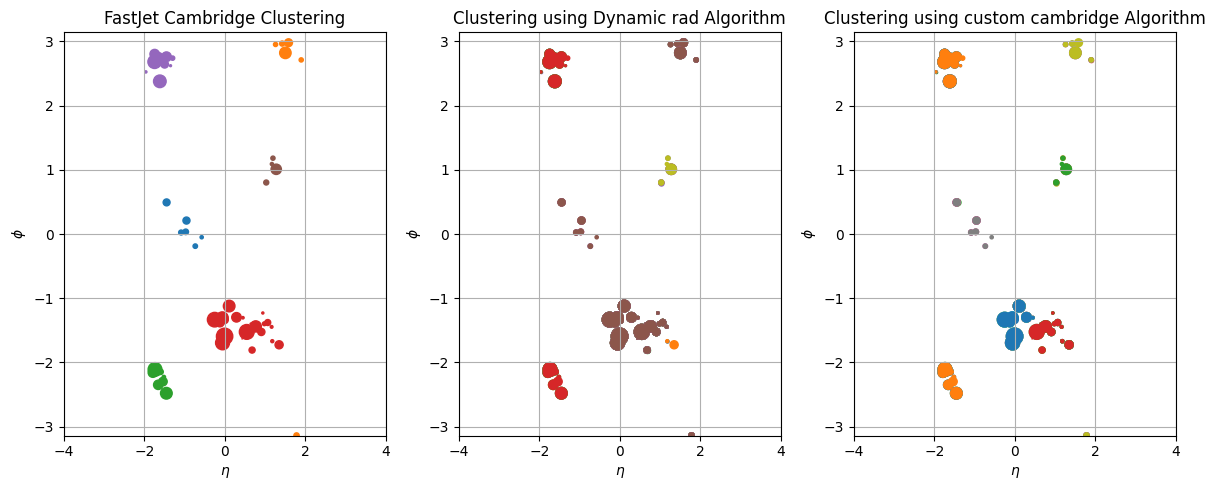

In [84]:
# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot results from FastJet Cambridge/Aachen Algorithm
for jet in fastjet_clusters:
    constituents = jet.constituents()
    phi_values = []
    for p in constituents:
        if p.phi() > np.pi:
            phi_values.append(p.phi() - 2 * np.pi)
        elif p.phi() < -np.pi:
            phi_values.append(p.phi() + 2 * np.pi)
        else:
            phi_values.append(p.phi())
    eta_values = [p.eta() for p in constituents]
    energy_values = [p.e() for p in constituents]
    axes[0].scatter(eta_values, phi_values, s=[10 * e for e in energy_values], alpha=1, label=f'Jet with pT={jet.pt():.2f}')
axes[0].set_ylim(-np.pi, np.pi)
axes[0].set_xlim(-4, 4)
axes[0].grid(True)
axes[0].set_title('FastJet Cambridge Clustering')
axes[0].set_xlabel(r'$\eta$')
axes[0].set_ylabel(r'$\phi$')

for constituents in jets_constituents1:
    consti_eta, consti_phi, consti_e = [],[],[]
    for i in range(len(constituents)):
        consti_eta.append(constituents[i][0])
        if constituents[i][1]>np.pi:
            consti_phi.append(constituents[i][1]-2*np.pi)
        elif constituents[i][1]<-np.pi:
            consti_phi.append(constituents[i][1]+2*np.pi)
        else:
            consti_phi.append(constituents[i][1])
        consti_e.append(constituents[i][3])
        axes[1].scatter(consti_eta, consti_phi, s=[10*e for e in consti_e])
axes[1].set_ylim(-np.pi,np.pi)
axes[1].set_xlim(-4,4)
axes[1].grid(True)
axes[1].set_xlabel(r'$\eta$')
axes[1].set_ylabel(r'$\phi$')
axes[1].set_title("Clustering using Dynamic rad Algorithm")

for constituents in jets_constituents:
    consti_eta, consti_phi, consti_e = [],[],[]
    for i in range(len(constituents)):
        consti_eta.append(constituents[i][0])
        if constituents[i][1]>np.pi:
            consti_phi.append(constituents[i][1]-2*np.pi)
        elif constituents[i][1]<-np.pi:
            consti_phi.append(constituents[i][1]+2*np.pi)
        else:
            consti_phi.append(constituents[i][1])
        consti_e.append(constituents[i][3])
        axes[2].scatter(consti_eta, consti_phi, s=[10*e for e in consti_e])
axes[2].set_ylim(-np.pi,np.pi)
axes[2].set_xlim(-4,4)
axes[2].grid(True)
axes[2].set_xlabel(r'$\eta$')
axes[2].set_ylabel(r'$\phi$')
axes[2].set_title("Clustering using custom cambridge Algorithm")

plt.tight_layout()
plt.show()
